In [1]:
pip install torch clip fastapi python-multipart pillow requests matplotlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.1 MB/s eta 0:00:00
  Crea

In [3]:
# First remove any existing incorrect installation
!pip uninstall clip -y

# Install official CLIP with PyTorch dependencies
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Found existing installation: clip 0.2.0
Uninstalling clip-0.2.0:
  Successfully uninstalled clip-0.2.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-nt36fhwn
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-nt36fhwn
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=719b2b74d666828022f12e1a2c1cda61bb4cc872318d133f58a643efe1736bd3
  Stored in directory: /tmp/pip-ephem-wheel-cache-x0p8y54q/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


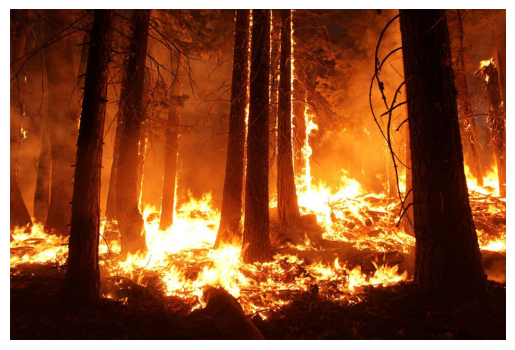


Disaster Classification Probabilities:
WILDFIRE: 33.33%
HURRICANE: 0.00%
EARTHQUAKE: 0.00%
FLOOD: 0.00%

Alert: WILDFIRE detected with 33.3% confidence!


In [7]:
import torch
import clip
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define disaster classes with descriptive prompts
disaster_classes = {
    "flood": [
        "a photo of a flood with water covering streets",
        "an image of submerged houses due to heavy rainfall",
        "aerial view of flooded urban area"
    ],
    "wildfire": [
        "a photo of a forest fire with smoke and flames",
        "burning trees in a wildfire",
        "aerial view of large wildfire spreading"
    ],
    "earthquake": [
        "a photo of collapsed buildings after earthquake",
        "cracked roads from seismic activity",
        "people in open space during earthquake shaking"
    ],
    "hurricane": [
        "a photo of strong winds and damaged roofs",
        "flooded coastal area during hurricane",
        "satellite image of hurricane vortex"
    ]
}

# Example disaster image (replace with your image URL/path)
image_url = "https://cdn.britannica.com/90/191790-050-092C8C2A/Wildfire-Stanislaus-National-Forest-California-2013.jpg"
#load image
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert("RGB")
plt.imshow(image)
plt.axis("off")
plt.show()

image_input = preprocess(image).unsqueeze(0).to(device)

# Prepare text prompts
text_descriptions = [desc for class_descs in disaster_classes.values() for desc in class_descs]
text_tokens = clip.tokenize(text_descriptions).to(device)

# Calculate similarity
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_tokens)

    # Compute similarity scores
    logits_per_image, _ = model(image_input, text_tokens)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

# Map probabilities to classes
class_probs = {}
start_idx = 0
for class_name, descs in disaster_classes.items():
    end_idx = start_idx + len(descs)
    class_probs[class_name] = probs[0, start_idx:end_idx].mean()
    start_idx = end_idx

# Display results
print("\nDisaster Classification Probabilities:")
for class_name, prob in sorted(class_probs.items(), key=lambda x: x[1], reverse=True):
    print(f"{class_name.upper()}: {prob * 100:.2f}%")

# Add decision threshold (e.g., 40%)
predicted_class = max(class_probs, key=class_probs.get)
confidence = class_probs[predicted_class]

if confidence > 0.2:
    print(f"\nAlert: {predicted_class.upper()} detected with {confidence * 100:.1f}% confidence!")
else:
    print("\nNo clear disaster pattern detected")